In [1]:
!pip install kaggle
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install tensorflow
!pip install tensorflow_decision_forests

In [2]:
! mkdir ~/.kaggle

!touch kaggle.json

!echo '{"username":"abinayasarasms","key":"f5910820c15b66b7f1bd9c82317b50d2"}' >> kaggle.json
!cp /content/kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip /content/house-prices-advanced-regression-techniques.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 95.1MB/s]
Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# 1. Import

In [2]:
# libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


import seaborn as sns


import tensorflow as tf
import tensorflow_decision_forests as tfdf

In [3]:
# data
df_train = pd.read_csv('/content/train.csv')
df_train.drop(['Id'], axis=1, inplace=True)
df_test = pd.read_csv('/content/test.csv')
df_test.drop(['Id'], axis=1, inplace=True)

In [6]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 2 Data Cleaning

## 2.1 Handling Missing Values

In [8]:
missing_value = df_train.isnull().sum().sort_values(ascending=False)
missing_value[missing_value>0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [9]:
# Greater than 50%: delete
df_cleaned = df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)

# Numerical Data
fillWithNumber = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
for col in fillWithNumber:
    df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)

# Type Data
fillWithType = ['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual',
       'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType', 'Electrical']
for col in fillWithType:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

df_cleaned.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [10]:
# Check
df_cleaned.isnull().sum().sum()

0

## 2.2 Outlier Treatment

In [11]:
# select data
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
length = len(numeric_columns)

#
for column in numeric_columns:
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_cleaned[column] = np.where(df_cleaned[column] < lower_bound, lower_bound, df_cleaned[column])
    df_cleaned[column] = np.where(df_cleaned[column] > upper_bound, upper_bound, df_cleaned[column])

# 3. Preprocessing

## 3.1 Data Splitting

In [12]:
df_train = df_cleaned[numeric_columns]
drop_columns = ['SalePrice']

X = df_train.drop(drop_columns, axis=1)
y = df_train[drop_columns]

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

SelectKBest = SelectKBest(f_regression, k=3)
bestFeature = SelectKBest.fit_transform(X, y)
SelectKBest.get_support()
X.columns[SelectKBest.get_support()]

Index(['OverallQual', 'GrLivArea', 'GarageCars'], dtype='object')

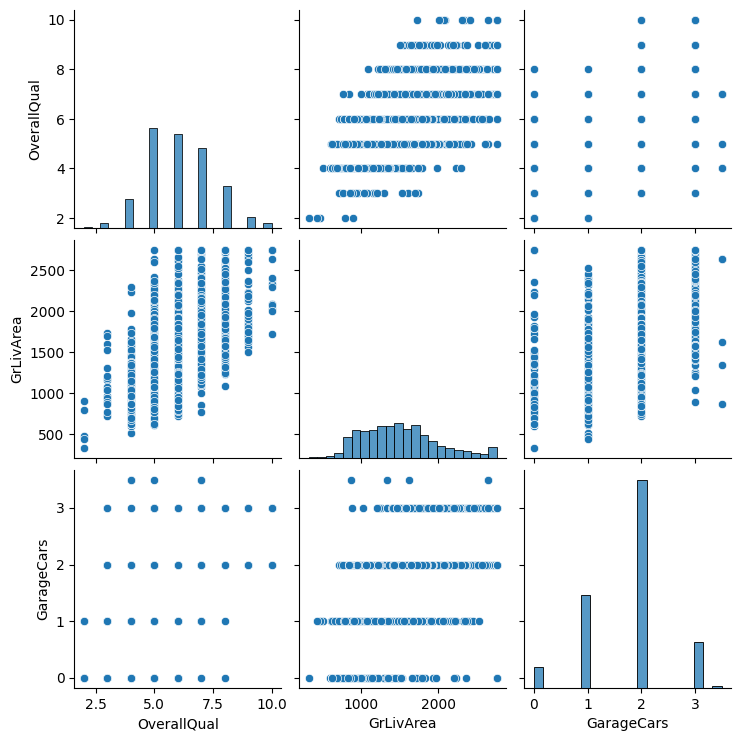

In [14]:
sns.pairplot(df_train[['OverallQual', 'GrLivArea', 'GarageCars']])

## 3.2 Feature normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for feature in df_train.columns:
    df_train['standard'+feature] = scaler.fit_transform(df_train[[feature]])

In [16]:
df_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,standardWoodDeckSF,standardOpenPorchSF,standardEnclosedPorch,standard3SsnPorch,standardScreenPorch,standardPoolArea,standardMiscVal,standardMoSold,standardYrSold,standardSalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.000000,0.358824,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,0.568924
1,20.0,80.0,9600.0,6.0,7.5,1976.0,1976.0,0.0,978.0,0.0,...,0.709524,0.000000,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,0.480439
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.000000,0.247059,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,0.618082
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.000000,0.205882,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,0.344435
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.457143,0.494118,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,0.704928


## 3.3 Predict

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_class = model.predict(X_test)

In [18]:
missing_value = df_test.isnull().sum().sort_values(ascending=False)
missing_value[missing_value>0]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType2      42
BsmtFinType1      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFullBath       2
KitchenQual        1
BsmtFinSF1         1
SaleType           1
TotalBsmtSF        1
GarageCars         1
Exterior2nd        1
Exterior1st        1
GarageArea         1
BsmtUnfSF          1
BsmtFinSF2         1
dtype: int64

In [19]:
df_test = df_test[X.columns]

# Numerical Data
fillWithNumber = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
for col in fillWithNumber:
    df_test[col].fillna(df_test[col].mean(), inplace=True)

df_test.fillna(0, inplace=True)

df_test.isnull().sum().sum()

0

In [20]:
y_pred = model.predict(df_test)
y_pred = y_pred.flatten()

In [21]:
output = pd.read_csv('/content/sample_submission.csv')
output['SalePrice'] = y_pred

output.to_csv('submission.csv', index=False)

output.head()

,Id,SalePrice
0,1461,125752.924145
1,1462,167838.209870
2,1463,187398.933702
3,1464,202080.493750
4,1465,181080.405172
